In [22]:
import pandas as pd
import h5py
import os
import numpy as np
from selenobot.datasets import Dataset, get_dataloader
import matplotlib.pyplot as plt
from selenobot.classifiers import *
import scipy.stats
from typing import List, Tuple, Dict, NoReturn
from tqdm import tqdm
from selenobot.files import *
from sklearn.metrics import balanced_accuracy_score
from scipy.stats import kstest, mannwhitneyu
from fabapi import Query
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import warnings
import matplotlib.colors 
import matplotlib.cm 
warnings.simplefilter('ignore')
import fabapi 
from tqdm import tqdm 
import re 

%load_ext autoreload
%autoreload 2

# Define some important directories...
ROOT_DIR = '..'
RESULTS_DIR = os.path.join(ROOT_DIR, 'results') # Get the path where results are stored.
MODELS_DIR = os.path.join(ROOT_DIR, 'models')
DATA_DIR = os.path.join(ROOT_DIR, 'data') # Get the path where results are stored. 
SCRIPTS_DIR = os.path.join(ROOT_DIR, 'scripts') # Get the path where results are stored.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# For the sake of speeding things up, going to use a subset of GTDB genomes. I will grab the highest-completion representative
# genome from each bacterial phylum. 
bacteria_metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'validation', 'bac120_metadata_r207.tsv'), sep='\t')
bacteria_metadata_df = bacteria_metadata_df[bacteria_metadata_df.gtdb_representative == 't'] # Get the representatives. 
# Extract the phylum... 
phylum = [re.search(r'p__([^;]+);', taxonomy).group(1) for taxonomy in bacteria_metadata_df.gtdb_taxonomy]
bacteria_metadata_df['phylum'] = phylum

print('Number of representative genomes:', len(bacteria_metadata_df))
print('Number of phyla:', len(np.unique(phylum)))

subset_df = [] # For storing the genome from each phylum with the highest completeness.. 
for _, phylum_df in bacteria_metadata_df.groupby('phylum'):
    phylum_df = phylum_df.sort_values('checkm_completeness', ascending=False)
    subset_df.append(phylum_df.iloc[0].copy())
subset_df = pd.DataFrame(subset_df)

# Remove the prefixes from the genome IDs. 
subset_df = subset_df.rename(columns={'accession':'genome_id'})
subset_df.genome_id = [genome_id.replace('GB_', '').replace('RS_', '') for genome_id in subset_df.genome_id]
subset_df.set_index('genome_id').to_csv(os.path.join(DATA_DIR, 'validation', 'bac120_metadata_r207_subset.csv'))

Number of representative genomes: 62291
Number of phyla: 169


In [ ]:
# Want to download the GTDB ORFs for the genomes in the subsample... 
# This is the genome with the highest completeness from each bacterial phylum!
genome_ids = pd.read_csv(os.path.join(DATA_DIR, 'validation', 'bac120_metadata_r207_subset.csv')).genome_id

# Obtain the relevant data from Find-A-Bug...
gtdb_df = []
for genome_id in tqdm(genome_ids, desc='Downloading genes from Find-A-Bug...'):
    genome_df = []
    query = fabapi.Query('proteins')
    query.equal_to('genome_id', genome_id)
    for page_df in query:
        genome_df.append(page_df)
    # Concatenate the results for the genome and add to the complete DataFrame. 
    genome_df = pd.concat(genome_df)
    gtdb_df.append(genome_df)  

gtdb_df = pd.concat(gtdb_df).set_index('gene_id')
gtdb_df.to_csv(os.path.join(DATA_DIR, 'validation', 'bac120_proteins_r207_subset.csv'))

Total number of proteins in the subset: 479429
Average length of proteins with length < 1000 aa: 311.1493109511523


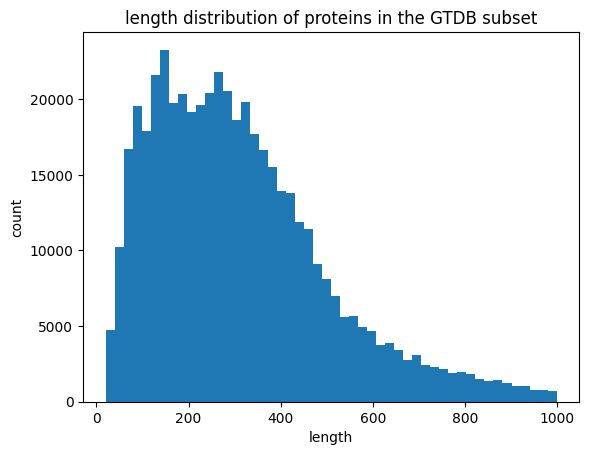

In [56]:
print('Total number of proteins in the subset:', len(gtdb_df))

# Also want to look at the length distribution, and possibly get rid of any clear outliers. 
gtdb_df['length'] = gtdb_df.seq.apply(len)

# After looking at the initial length distribution, there are definitely some crazy outliers. 
# It seems like there *can* be bacterial sequences that long, but I don't want to deal with them. 
length_threshold = 1000
# print((gtdb_df.length >= length_cutoff).sum(), f'proteins exceed the length threshold of {length_threshold}.')

gtdb_df = gtdb_df[gtdb_df.length < length_threshold]
gtdb_df.to_csv(os.path.join(DATA_DIR, 'validation', f'bac120_proteins_r207_subset_max_length_{length_threshold}.csv'))
print(f'Average length of proteins with length < {length_threshold} aa:', gtdb_df.length.mean())

fig, ax = plt.subplots()
ax.hist(gtdb_df.length, bins=50)
ax.set_title('length distribution of proteins in the GTDB subset')
ax.set_xlabel('length')
ax.set_ylabel('count')
plt.show()

In [7]:
dir(query)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_field',
 'base_url',
 'connector',
 'count',
 'equal_to',
 'fields',
 'filters',
 'get',
 'greater_than',
 'greater_than_or_equal_to',
 'in_range',
 'less_than',
 'less_than_or_equal_to',
 'next',
 'operators',
 'page',
 'symbols',
 'table_name']

In [22]:
# Dataset exploration, after going through the hassle of removing potentially fragmented proteins. 
train_metadata_df = pd.read_hdf(os.path.join(DATA_DIR, 'train.h5'), key='metadata')
test_metadata_df = pd.read_hdf(os.path.join(DATA_DIR, 'test.h5'), key='metadata')
val_metadata_df = pd.read_hdf(os.path.join(DATA_DIR, 'val.h5'), key='metadata')

print('Training dataset size:', len(train_metadata_df))
print('Validation dataset size:', len(val_metadata_df))
print('Testing dataset size:', len(test_metadata_df))

# assert not np.any(np.isin(train_metadata_df.index, test_metadata_df.index)), 'Datasets are not disjoint!'
# assert not np.any(np.isin(train_metadata_df.index, val_metadata_df.index)), 'Datasets are not disjoint!'

for id_ in tqdm(train_metadata_df.index):
    assert not (id_ in val_metadata_df.index), 'Datasets are not disjoint!'
    assert not (id_ in test_metadata_df.index), 'Datasets are not disjoint!'

# Make sure there are no fragmented proteins... Remember that I allowed fragments that didn't occur at the beginning for the 
# # selenoproteins, because they are truncated anyway. 
# for metadata_df in [train_metadata_df, test_metadata_df, val_metadata_df]:
#     sec_metadata_df = metadata_df[metadata_df.label == 1]
#     full_length_metadata_df = metadata_df[metadata_df.label == 0]

#     assert np.all(full_length_metadata_df.non_terminal_residue.isnull()), 'There are some fragmented proteins!'
#     # Get the non-terminal amino acid locations. 
#     no_fragment_at_position_one = [('1' not in entry.split(',')) for entry in sec_metadata_df.non_terminal_residue if (type(entry) == str)]
#     assert np.all(no_fragment_at_position_one), 'There are some fragmented proteins!'

Training dataset size: 223386
Validation dataset size: 55909
Testing dataset size: 71750


100%|██████████| 223386/223386 [00:00<00:00, 261586.60it/s]


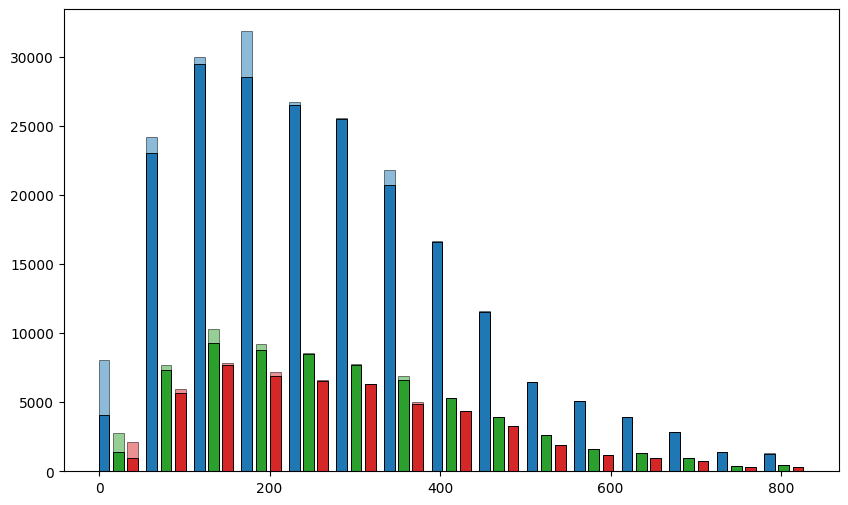

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
width = 50
colors = ['tab:blue', 'tab:green', 'tab:red']
offsets = [0, 0.3, 0.6]

hists = []
bins = None
for color, offset, metadata_df in zip(colors, offsets, [train_metadata_df, test_metadata_df, val_metadata_df]):
    lengths = metadata_df.seq.apply(len)
    sec_lengths = lengths[metadata_df.label == 1]
    full_lengths = lengths[metadata_df.label == 0]

    sec_hist, sec_bins = np.histogram(sec_lengths, bins=15 if (bins is None) else bins)
    bins = sec_bins if (bins is None) else bins

    full_hist, _ = np.histogram(full_lengths, bins=bins)

    bin_width = bins[1] - bins[0]
    x_vals = bins[:-1] + bin_width * offset

    ax.bar(x_vals, full_hist, width=0.25 * width, color=color, linewidth=0.7, edgecolor='black')
    ax.bar(x_vals, sec_hist, width=0.25 * width, color=color, alpha=0.5, bottom=full_hist, linewidth=0.7, edgecolor='black') # , hatch='////')

legend = []

In [65]:
# file = NcbiXmlFile(os.path.join(DATA_DIR, 'uniprot_sec.xml'))
# file.to_df().to_csv(os.path.join(DATA_DIR, 'uniprot_sec.csv'))

NcbiXmlFile.__init__: Parsing NCBI XML file, row 19901...: : 6718788it [01:23, 80485.91it/s]


In [23]:
df = pd.read_csv(os.path.join(DATA_DIR, 'uniprot_short.csv'))
print('Number of short complete proteins:', (df.non_terminal_residue.isnull()).sum())
print('Number of short fragment proteins:', (~df.non_terminal_residue.isnull()).sum())
# So it seems that about half of the obatined short proteins are fragmented...

df = pd.read_csv(os.path.join(DATA_DIR, 'uniprot_sprot.csv'))
print('\nNumber of complete proteins in SwissProt:', (df.non_terminal_residue.isnull()).sum())
print('Number of fragment proteins in SwissProt:', (~df.non_terminal_residue.isnull()).sum())

df = pd.read_csv(os.path.join(DATA_DIR, 'uniprot_sec.csv'))
print('\nNumber of complete selenoproteins:', (df.non_terminal_residue.isnull()).sum())
print('Number of fragment selenoproteins:', (~df.non_terminal_residue.isnull()).sum())

# Will want to remove selenoproteins which are incomplete from the first amino acid, but not a big
# deal if they're incomplete at the N terminus. 

Number of short complete proteins: 88609
Number of short fragment proteins: 0

Number of complete proteins in SwissProt: 808501
Number of fragment proteins in SwissProt: 11026

Number of complete selenoproteins: 18610
Number of fragment selenoproteins: 1291


In [ ]:
train_df = pd.read_hdf(os.path.join(DATA_DIR, 'test.h5'), key='metadata')
# train_df = train_df[train_df.non_terminal_residue.isnull()]
train_df_truncated = train_df[train_df.label == 1]
train_df_full_length = train_df[train_df.label == 0]

print('Shortest protein in the training dataset:', min(train_df.seq.apply(len)))
print('Shortest truncated protein in the training dataset:', min(train_df_truncated.seq.apply(len)))
print('Shortest full-length protein in the training dataset:', min(train_df_full_length.seq.apply(len)))

In [39]:
train_df_full_length['length'] = train_df.seq.apply(len)
# I am curious to see how the model behaves on sequences shorter than the shortest in the training set. 
# The shortest amino acid sequence in UniProt is apparently 7 amino acids long. Why are there some in my training data that are shorter, despite being
# full-length?

# Look into "non-terminal residue" flag on some proteins. 

print('Number of full-length sequences shorter than 10 aa:', (train_df_full_length.length < 10).sum())
print('Number of full-length sequences shorter than 20 aa:', (train_df_full_length.length < 20).sum())
print('Number of full-length sequences shorter than 30 aa:', (train_df_full_length.length < 30).sum())
train_df_full_length.sort_values('length', ascending=True)

Numbes of full-length sequences shorter than 10 aa: 10
Numbes of full-length sequences shorter than 20 aa: 70
Numbes of full-length sequences shorter than 30 aa: 148


,domain,kingdom,phylum,class,order,family,genus,species,ncbi_taxonomy_id,refseq_protein_id,refseq_nucleotide_id,seq,name,sec_index,sec_count,trunc,cluster,label,length
id,,,,,,,,,,,,,,,,,,,
P83533,Bacteria,Bacillota,Bacilli,Lactobacillales,Lactobacillaceae,Fructilactobacillus,NaN,UP05_FRUSA,1625,NaN,NaN,DTVNAA,UP05_FRUSA,NaN,NaN,NaN,121,0,6
P16101,Bacteria,Pseudomonadota,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Alcaligenes,NaN,CHOX_ALCSP,512,NaN,NaN,DNPNHSR,CHOX_ALCSP,NaN,NaN,NaN,141153,0,7
Q47505,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,NaN,MCCC7_ECOLX,562,NaN,NaN,MRTGNAN,MCCC7_ECOLX,NaN,NaN,NaN,15937,0,7
P83530,Bacteria,Bacillota,Bacilli,Lactobacillales,Lactobacillaceae,Fructilactobacillus,NaN,UP02_FRUSA,1625,NaN,NaN,VTLDVED,UP02_FRUSA,NaN,NaN,NaN,1095,0,7
P0DPN7,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,NaN,YMDG_ECOLI,83333,NaN,NaN,MKNSVAEH,YMDG_ECOLI,NaN,NaN,NaN,141152,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q2T4N2,Bacteria,Pseudomonadota,Betaproteobacteria,Burkholderiales,Burkholderiaceae,Burkholderia,pseudomallei group,THAH_BURTA,271848,NaN,NaN,MPRWRPTWLKRLSCPKQPRHPTHPKHPTHPKHPKHPKHPRHPKHPR...,THAH_BURTA,NaN,NaN,NaN,25,0,3925
Q9R9J1,Bacteria,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,NaN,MYCA_BACIU,1423,NaN,NaN,MYTSQFQTLVDVIRNRSNISDRGIRFIESDKIETFVSYRQLFDEAQ...,MYCA_BACIU,NaN,NaN,NaN,24,0,3971
O68006,Bacteria,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,NaN,BACA_BACLI,1402,NaN,NaN,MVAKHSLENGVFHKMTENEKELILHFNNTKTDYPKNKTLHELFEEQ...,BACA_BACLI,NaN,NaN,NaN,11,0,5255


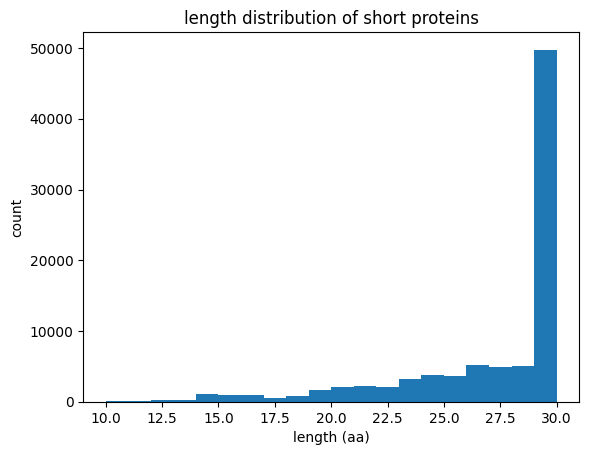

In [78]:
# These sequences were obtained from UniProt TREMBL (i.e. not reviewed). All sequences are bacterial, and the length range was specified
# as anywhere from 10 to 30 amino acids. 
short_df = pd.read_csv(os.path.join(DATA_DIR, 'uniprot_short.csv'), index_col='id')
short_df = short_df[short_df.non_terminal_residue.isnull()]
short_df.to_csv(os.path.join(DATA_DIR, 'uniprot_short.csv'))

lengths = short_df.seq.apply(len)

fig, ax = plt.subplots(1)
ax.hist(lengths, bins=20)
ax.set_xlabel('length (aa)')
ax.set_ylabel('count')
ax.set_title('length distribution of short proteins')
plt.show()


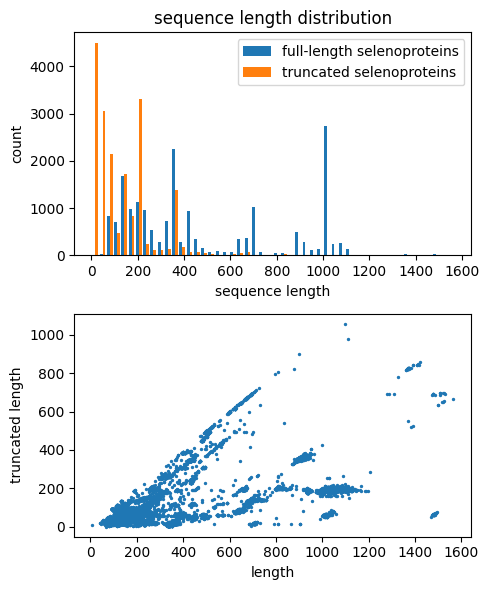

In [35]:
# Want to generate a dataset containing truncated non-selenoproteins and short full-length proteins.

# Length distribution of truncated selenoproteins... 
sec_df = pd.read_csv(os.path.join(DATA_DIR, 'uniprot_sec.csv'))

# Filter out proteins which are complete on both sides. 
sec_df_complete = sec_df[sec_df.non_terminal_residue.isnull()]
# sec_df_half_complete = sec_df[np.array([(type(ntr) == str) and ('1' not in ntr.split(',')) for ntr in sec_df.non_terminal_residue])]

# seqs = sec_df.seq.values 

full_lengths = [len(seq) for seq in sec_df_complete.seq]
truncated_lengths = [len(seq[:seq.index('U')]) for seq in sec_df_complete.seq]
truncation_amounts = [len(seq) - len(seq[:seq.index('U')]) for seq in sec_df_complete.seq] 

fig, axes = plt.subplots(nrows=2, figsize=(5, 6))
bins = axes[0].hist((full_lengths, truncated_lengths), bins=50)
# ax.hist(truncated_lengths)

axes[0].set_xlabel('sequence length')
axes[0].set_ylabel('count')
axes[0].set_title('sequence length distribution')
axes[0].legend(['full-length selenoproteins', 'truncated selenoproteins'])

axes[1].scatter(full_lengths, truncated_lengths, s=2)
axes[1].set_xlabel('length')
axes[1].set_ylabel('truncated length')
# axes[1].scatter(full_lengths, np.array(truncation_amounts) / np.array(full_lengths), s=2)
# axes[1].set_xlabel('length')
# axes[1].set_ylabel('truncated fraction')

fig.tight_layout()
plt.show()


In [26]:
# Want to extract a subset of seq
test_df = pd.read_hdf(os.path.join(DATA_DIR, 'test.h5'), key='metadata')
test_df = test_df[test_df.label == 0] # Grab all non-selenoproteins. 
test_df['length'] = test_df.seq.apply(len)
print(len(test_df), 'full-length non-selenoproteins in the dataset.\n')

print('Median length of full-length proteins:', test_df.length.median())
print('Mean length of full-length proteins:', test_df.length.mean())
print('Median truncation amount:', np.median(truncation_amounts), f'({min(truncation_amounts)} - {max(truncation_amounts)})')
print('Mean truncation amount:', np.mean(truncation_amounts))

# short_proteins_df = test_df[test_df.length < 100].sample(5000)
# # print(len(short_proteins_df), 'sequences in the test dataset with length < 100')
# df = test_df[test_df.length > 300].sample(5000) # Down-sample to reduce computation. 
df = sample(test_df, n=10000) # Down-sample to reduce computation. 
# print(len(longer_proteins_df), 'sequences in the test dataset with length > 300')

trunc_df = []
for id_, row in zip(df.index, df.to_dict(orient='records', index=True)):
    row['truncation'] = 0
    row['id'] = id_ + '[0]'
    trunc_df.append(row)

    seq = row['seq']
    for r in 0.1 * np.arange(10):
        row = row.copy()
        t = int(len(row['seq']) * r)
        row['truncation_ratio'] = r
        row['truncation_size'] = t
        row['seq'] = seq[:-t]
        row['id'] = id_ + f'[{int(r * 10)}%]'
        trunc_df.append(row)
trunc_df = pd.DataFrame(trunc_df).set_index('id')

print(f'\nWriting {len(trunc_df)} truncated sequences to {os.path.join(DATA_DIR, 'uniprot_truncated.csv')}')
trunc_df.to_csv(os.path.join(DATA_DIR, 'uniprot_truncated.csv'))

67068 full-length non-selenoproteins in the dataset.

Median length of full-length proteins: 272.0
Mean length of full-length proteins: 312.4026659509751
Median truncation amount: 315.0 (1 - 1424)
Mean truncation amount: 353.1689362343601
sample: Dropping 23 sequences which are not assigned a taxonomic category at level class.

Writing 110000 truncated sequences to ../data/uniprot_truncated.csv


In [23]:
def sample(metadata_df:pd.DataFrame, n:int=5000, level:str='class'):
    '''Sample proteins from the dataset such that phylogenetic categories are evenly represented.'''
    n_categories = len(metadata_df[level].dropna().unique())
    n_per_category = n // n_categories

    # Drop everything which has not been assigned a taxonomic category at the specified level. 
    print(f'sample: Dropping {metadata_df[level].isnull().sum()} sequences which are not assigned a taxonomic category at level {level}.') 
    metadata_df = metadata_df[~metadata_df[level].isnull()]

    sample_df = []
    for _, df in metadata_df.groupby(level, as_index=False):
        sample_df.append(df.sample(min(len(df), n_per_category), replace=False))
    sample_df = pd.concat(sample_df)

    # Remove all sequences which have already been sampled from the original metadata DataFrame. 
    metadata_df = metadata_df[~metadata_df.index.isin(sample_df.index)]
    n_missing = n - len(sample_df)
    # Sample enough sequences to meet the sample size requirement. 
    sample_df = pd.concat([sample_df, metadata_df.sample(n_missing)])

    return sample_df

In [24]:
sample(test_df)

sample: Dropping 23 sequences which are not assigned a taxonomic category at level class.


,domain,kingdom,phylum,class,order,family,genus,species,ncbi_taxonomy_id,refseq_protein_id,refseq_nucleotide_id,seq,name,sec_index,sec_count,trunc,cluster,label,length
id,,,,,,,,,,,,,,,,,,,
B0BZ38,Bacteria,Cyanobacteriota,Cyanophyceae,Acaryochloridales,Acaryochloridaceae,Acaryochloris,NaN,EX7L_ACAM1,329726,WP_012163740.1,NC_009925.1,MTSYQPNLLVPPEVLSVKGLTDYIQTLLEDDSYLVQVWVEGEVSSA...,EX7L_ACAM1,NaN,NaN,NaN,32124,0,418
Q8DKM3,Bacteria,Cyanobacteriota,Cyanophyceae,Acaryochloridales,Thermosynechococcaceae,Thermosynechococcus,NaN,PSBY_THEVB,197221,NP_681626.1,NC_004113.1,MDWRVLVVLLPVLLAAGWAVRNILPYAVKQVQKLLQKAKAA,PSBY_THEVB,NaN,NaN,NaN,138127,0,41
B0C118,Bacteria,Cyanobacteriota,Cyanophyceae,Acaryochloridales,Acaryochloridaceae,Acaryochloris,NaN,RPOZ_ACAM1,329726,WP_010481519.1,NC_009925.1,MSKRPTIDTTHIMRRAEELISASSNRYRITVQVANRAKKRRRRENL...,RPOZ_ACAM1,NaN,NaN,NaN,132811,0,76
Q8DMV6,Bacteria,Cyanobacteriota,Cyanophyceae,Acaryochloridales,Thermosynechococcaceae,Thermosynechococcus,NaN,URE1_THEVB,197221,NP_680796.1,NC_004113.1,MSYRIDRQTYAETYGPTVGDRLRLADTDLIIEIEHDYTHYGDEVKF...,URE1_THEVB,NaN,NaN,NaN,13007,0,572
B0CED7,Bacteria,Cyanobacteriota,Cyanophyceae,Acaryochloridales,Acaryochloridaceae,Acaryochloris,NaN,PYRB_ACAM1,329726,WP_012162405.1,NC_009925.1,MAETTWNRHHVLSLADFSADELNIVLQTANSFKDVLYRKTKKVPTL...,PYRB_ACAM1,NaN,NaN,NaN,55105,0,323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q3K3U5,Bacteria,Bacillota,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,NaN,RS11_STRA1,205921,WP_001118387.1,NC_007432.1,MAKPTRKRRVKKNIESGVAHIHATFNNTIVMITDVHGNALAWSSAG...,RS11_STRA1,NaN,NaN,NaN,118349,0,127
A8GQR9,Bacteria,Pseudomonadota,Alphaproteobacteria,Rickettsiales,Rickettsiaceae,Rickettsieae,Rickettsia,RL28_RICRS,392021,WP_012150358.1,NZ_CP121767.1,MSRKCELTGVGVLYGNNVSHSQRKTRRRFEPNLRSVKFTSDITAGE...,RL28_RICRS,NaN,NaN,NaN,127038,0,97
B7KJK8,Bacteria,Cyanobacteriota,Cyanophyceae,Oscillatoriophycideae,Chroococcales,Aphanothecaceae,Gloeothece,PUR5_GLOC7,65393,WP_015957261.1,NC_011729.1,MDYKEAGVDVEAGRNFVEKIKKKVESTHRPEVLGGLGGFGGFFQIP...,PUR5_GLOC7,NaN,NaN,NaN,49959,0,342


In [5]:
train_dataset = Dataset.from_hdf(os.path.join(DATA_DIR, 'train.h5'))

In [18]:
# Seems like it would be a good idea to fix the number of training cycles for the balanced batches
# and weighted loss models in order to control for any effects due to the number of batches per epoch being
# higher (as opposed to the total number of batches). 

# How many batches per epoch with balanced batches?
dataloader = get_dataloader(train_dataset, balance_batches=True)
print('Batches per epoch with balance_batches=True:', len(dataloader))
dataloader = get_dataloader(train_dataset, balance_batches=False)
print('Batches per epoch with balance_batches=False:', len(dataloader))

get_dataloader: 1981070 samples required for dataset coverage.
Batches per epoch with balance_batches=True: 123817
Batches per epoch with balance_batches=False: 14130


In [19]:
# If we train the balanced batch version for 1000 epochs, the model sees 123817 * 1000 = 123817000 batches.
batches_per_epoch = 123817
n_epochs = 100

print('Epochs required for weighted loss model for equivalent number of batches:', int(12381700 / 14130))

Epochs required for weighted loss model for equivalent number of batches: 876


In [37]:
# dataset = Dataset.from_hdf(os.path.join(DATA_DIR, 'uniprot_truncated.h5'), feature_type='plm')

# # print('Number of instances seen (balance batches):', model_balance_batches.instances_seen_during_training)
# print('Number of epochs (balance batches):', model_balance_batches.epochs)
# # print('Number of instances seen (weighted loss):', model_weighted_loss.instances_seen_during_training)

# fig, ax = plt.subplots()

# model = Classifier.load(os.path.join(MODELS_DIR, 'model_epochs_1000_lr_e8.pkl'))
# predictions = model.predict(dataset)
# print('Test accuracy:', balanced_accuracy_score(dataset.labels, predictions))

# trunc_df = dataset.metadata
# trunc_df['prediction'] = predictions

# x_vals, y_vals = [], []
# for t, df in trunc_df.groupby('truncation'):
#     acc = balanced_accuracy_score(df.label.values, df.prediction.values)
#     y_vals.append(acc)
#     x_vals.append(t)

# ax.plot(x_vals, y_vals)

# ax.set_xlabel('epoch')
# ax.set_ylabel('')
# ax.legend(['balanced batches', 'weighted loss'])
# plt.show()

In [41]:
dataset.metadata
dataset.metadata.truncation.values / dataset.metadata.length.values


array([0.        , 0.02207506, 0.11037528, ..., 0.29850746, 0.59701493,
       0.89552239])

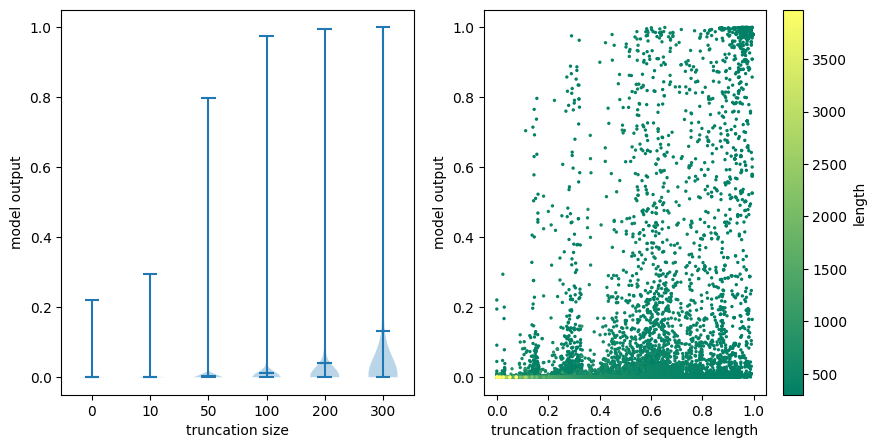

In [73]:
# Seems like a good idea to express truncation as a proportion of the protein's length. 
model_balance_batches = Classifier.load(os.path.join(MODELS_DIR, 'model_balance_batches.pkl'))
dataset = Dataset.from_hdf(os.path.join(DATA_DIR, 'uniprot_truncated.h5'), feature_type='plm')

metadata = dataset.metadata.copy()
metadata['prediction'] = model_balance_batches.predict(dataset, threshold=None).ravel()
metadata = metadata.sort_values('length')
data, positions = [], []
for truncation, df in metadata.groupby('truncation'):
    # data.append(np.round(df.prediction.values, 1))
    data.append(df.prediction.values.ravel())
    positions.append(truncation)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].violinplot(np.array(data).T, showmeans=True)
axes[0].set_xticklabels([0] + positions)
axes[0].set_ylabel('model output')
axes[0].set_xlabel('truncation size')

# cmap = matplotlib.colors.Colormap('Blues', N=256)
# cmap = plt.get_cmap('Blues')
norm = matplotlib.colors.Normalize(vmin=min(metadata.length.values.ravel()), vmax=max(metadata.length.values.ravel()))
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap='summer')

colors = cmap.to_rgba(metadata.length.values.ravel())

axes[1].scatter(metadata.truncation / metadata.length, metadata.prediction, s=2, c=colors)
cbar = plt.colorbar(ax=axes[1], mappable=cmap)
cbar.set_label('length')
axes[1].set_xlabel('truncation fraction of sequence length')
axes[1].set_ylabel('model output')

plt.show()

In [57]:
positions

[0, 10, 50, 100, 200, 300]

In [12]:
sec_df = pd.read_csv(os.path.join(DATA_DIR, 'uniprot_sec.csv'))

print('Fraction of bacteria:', sec_df.domain.str.match('Bacteria').mean())
print('Fraction of archaea:', sec_df.domain.str.match('Archaea').mean())
print('Fraction of eukaryotes:', sec_df.domain.str.match('Eukaryota').mean())
print('Fraction of viruses:', sec_df.domain.str.match('Viruses').mean())

# As far as selenoprotein machinery goes, I think it's more similar between archaea and eukaryotes than with bacteria. 
# (though I need to find a source for that). Perhaps it would be interesting to hold out non-bacteria, and see how it generalizes later on. 
 

Fraction of bacteria: 0.8265916285613788
Fraction of archaea: 0.01175820310537159
Fraction of eukaryotes: 0.15451484850007538
Fraction of viruses: 0.0002512436560976835


Balanced accuracy on the testing dataset: 0.9966


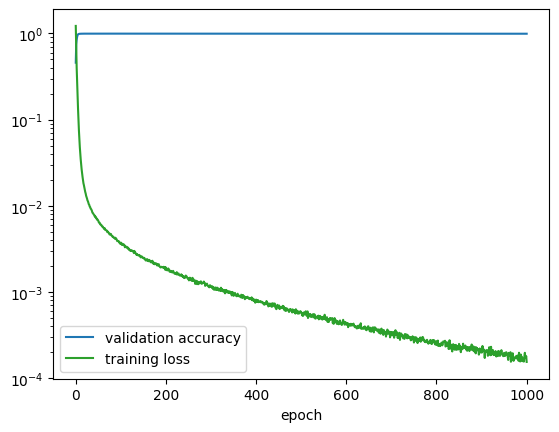

Best validation accuracy: 0.9936355175773343
Best epoch: 999


In [52]:
model = Classifier.load(os.path.join(MODELS_DIR, 'model_epochs_1000_lr_e8.pkl'))
fig, ax = plt.subplots()
ax.plot(np.arange(len(model.val_accs)), model.val_accs, c='tab:blue')
ax.plot(np.arange(len(model.train_losses)), model.train_losses, c='tab:green') # , ls='--')

test_dataset = Dataset.from_hdf(os.path.join(DATA_DIR, 'test.h5'))
predictions = model.predict(test_dataset).ravel()
test_acc = balanced_accuracy_score(test_dataset.labels.numpy(), predictions)
print('Balanced accuracy on the testing dataset:', np.round(test_acc, 4))


ax.set_xlabel('epoch')
ax.legend(['validation accuracy', 'training loss',])
ax.set_yscale('log')
plt.show()

print('Best validation accuracy:', model.val_accs[model.best_epoch])
print('Best epoch:', model.best_epoch)

In [49]:
print(len(test_dataset.labels))
print(len(predictions.ravel()))

71744
71744


In [6]:
test_dataset = Dataset.from_hdf(os.path.join(DATA_DIR, 'test.h5'))
test_predictions = model.predict(test_dataset)

print('Test accuracy:', balanced_accuracy_score(test_dataset.labels, test_predictions))
# print('Test accuracy (balance batches):', balanced_accuracy_score(test_dataset.labels, test_predictions_bb))

# For 2000 epochs, learning rate e-8: 0.9943182517917055
# For 1000 epochs, learning rate e-6: 0.9891197858353995
# For 1000 epochs, learning rate e-7: 0.9915394770126511
# For 1000 epochs, learning rate e-8: 0.9939928067866008


Test accuracy: 0.9939179416532318


In [30]:
# Want to make sure the balanced batch sampler is working correctly. 
# train_dataset = Dataset(pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('gene_id'))
dataloader = get_dataloader(train_dataset, batch_size=16, balance_batches=True)

get_dataloader: 3359210 samples required for dataset coverage.


In [36]:
r0, r1 = [], []
n_batches = len(dataloader)
print(n_batches, 'batches in the DataLoader.')
gene_ids = []

for batch in dataloader:
    batch_labels = batch['label']
    batch_size = len(batch_labels)
    r0.append((batch_size - batch_labels.sum().item()) / batch_size)
    r1.append(batch_labels.sum().item() / batch_size)
    gene_ids.append(batch['gene_id'])

gene_ids = np.unique(np.concatenate(gene_ids).ravel())
print(f'Saw {len(gene_ids)} unique gene IDs.')
print('Average proportion of selenoproteins per batch:', np.mean(r1))
print('Average proportion of non-selenoproteins per batch:', np.mean(r0))


209951 batches in the DataLoader.
Saw 371236 unique gene IDs.
Average proportion of selenoproteins per batch: 0.4996790917880839
Average proportion of non-selenoproteins per batch: 0.5003209082119161


# Dataset exploration

In [4]:
sec_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sec.fa'))
sec_truncated_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sec.fa'))
sprot_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sprot.fa'))

print('Number of selenoproteins:', len(sec_fasta_file))
print('Number of selenoproteins (truncated):', len(sec_truncated_fasta_file))
print('Number of SwissProt sequences:', len(sprot_fasta_file))

Number of selenoproteins: 18988
Number of selenoproteins (truncated): 18988
Number of SwissProt sequences: 569539


In [5]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), usecols=['gene_id'])
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), usecols=['gene_id'])
val_df = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'), usecols=['gene_id'])

print('Size of training data:', len(train_df))
print('Size of testing data:', len(test_df))
print('Size of validation data:', len(val_df))

Size of training data: 374775
Size of testing data: 119485
Size of validation data: 94000


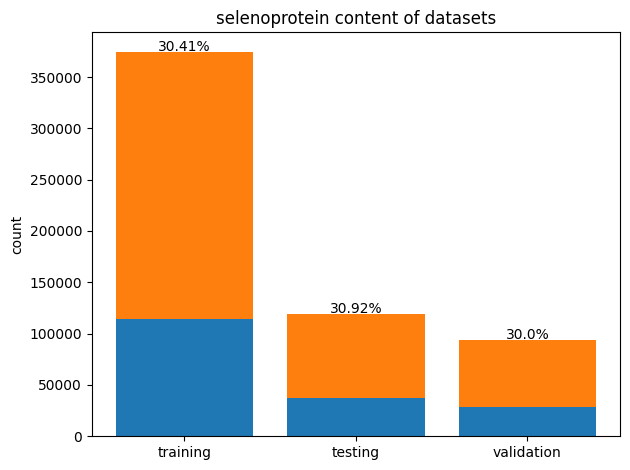

In [6]:
fig, ax = plt.subplots()

sec, non_sec = [], []
for i, df in enumerate([train_df, test_df, val_df]):
    n = np.sum(df.gene_id.str.contains(r'[1]'))
    sec.append(n)
    non_sec.append(len(df) - n)

    ax.text(i, len(df) + 1000, str(np.round(n / len(df) * 100, 2)) + '%', ha='center')

ax.bar(np.arange(3), sec)
ax.set_title('selenoprotein content of datasets')
ax.bar(np.arange(3), non_sec, bottom=sec)
ax.set_ylabel('count')
ax.set_xticks(np.arange(3), labels=['training', 'testing', 'validation'])

plt.tight_layout()

plt.show()


In [48]:
# dir_name = 'epochs_1000_lr_e8_no_scale' 
dir_name = 'epochs_10_lr_e3_balance_batches' # This is basically what the old model was. 

gtdb_results_df = pd.read_csv(os.path.join(f'../results/{dir_name}', 'gtdb_results.csv'), dtype={'partial':str})
# print(gtdb_results_df.columns)

def count_unique(df:pd.DataFrame):
    return len(df.index.unique())


n = count_unique(gtdb_results_df)
gtdb_results_df = gtdb_results_df[gtdb_results_df.partial.str.match('00')] # Look at only totally complete genes...
print(f'Removed {n - count_unique(gtdb_results_df)} incomplete proteins. {count_unique(gtdb_results_df)} predicted selenoproteins remaining.')
gtdb_results_df.set_index('gene_id').to_csv(f'../results/{dir_name}/gtdb_results_complete_only.csv')

# n = count_unique(gtdb_results_df)
# gtdb_results_df = gtdb_results_df[gtdb_results_df.sec_trna_count > 0] # Require at least one Sec tRNA. 
# print(f'Removed {n - count_unique(gtdb_results_df)} with no Sec tRNA. {count_unique(gtdb_results_df)} predicted selenoproteins remaining.')

print(count_unique(gtdb_results_df), 'predicted selenoproteins in GTDB.')
print(len(gtdb_results_df.genome_id.unique()), 'genomes with predicted selenoproteins in GTDB (65703 total genomes).')

Removed 809979 incomplete proteins. 1378457 predicted selenoproteins remaining.
1378457 predicted selenoproteins in GTDB.
63766 genomes with predicted selenoproteins in GTDB (65703 total genomes).


In [53]:
genome_data_all_df = pd.read_csv(os.path.join(f'../results', 'gtdb_genome_data_all.csv'))
copy_nums_df = pd.read_csv(os.path.join(f'../results', dir_name, 'gtdb_copy_nums.csv'))

genomes_with_selenoproteins = gtdb_results_df.genome_id.unique()
genome_data_no_sec_df = genome_data_all_df[~genome_data_all_df.genome_id.isin(genomes_with_selenoproteins)]
genome_data_no_sec_df = genome_data_no_sec_df.merge(copy_nums_df, on='genome_id', how='left')
genome_data_no_sec_df.set_index('genome_id').to_csv(os.path.join('../results/', dir_name, 'gtdb_genome_data_no_sec.csv'))
genomes_no_sec_df = pd.read_csv(os.path.join('../results', dir_name, 'gtdb_genome_data_no_sec.csv'))


In [54]:
sec_fractions_df = []
for genome_id, df in gtdb_results_df.groupby('genome_id'):
    sec_fraction = len(df) / df.protein_count.iloc[0]
    # Should only be one element in this DataFrame after dropping duplicates. 
    df = df[['sec_trna_count', 'sela_copy_num', 'selb_copy_num', 'seld_copy_num']].drop_duplicates()
    df['genome_id'] = genome_id
    df['sec_fraction'] = sec_fraction
    sec_fractions_df.append(df)
sec_fractions_df = pd.concat(sec_fractions_df)

genome_data_no_sec_df['sec_fraction'] = 0
sec_fractions_df = pd.concat([sec_fractions_df, genome_data_no_sec_df[['sec_trna_count', 'sela_copy_num', 'selb_copy_num', 'seld_copy_num', 'sec_fraction', 'genome_id']]])
sec_fractions_df.reset_index(drop=True).set_index('genome_id').to_csv(os.path.join(f'../results/{dir_name}', 'gtdb_sec_fractions.csv'))

In [55]:
for stop_codon, df in gtdb_results_df.groupby('stop_codon'):
    print(stop_codon, len(df))

n = count_unique(gtdb_results_df)
gtdb_results_df = gtdb_results_df[gtdb_results_df.stop_codon.str.match('TGA')] # Require at least one Sec tRNA. 
print(f'Removed {n - count_unique(gtdb_results_df)} without a UGA stop codon. {count_unique(gtdb_results_df)} predicted selenoproteins remaining.')
gtdb_results_df.set_index('gene_id') #.to_csv('../results/epochs_2000_lr_e8/gtdb_results_complete_and_uga_stop_only.csv')

# TAA 1321276
# TAG 1034218
# TGA 2135320


TAA 325166
TAG 315739
TGA 737552
Removed 640905 without a UGA stop codon. 737552 predicted selenoproteins remaining.


,model_output,prediction,gtdb_version,genome_id,aa_seq,start,stop,start_codon,stop_codon,gc_content,...,l50_scaffolds,n50_contigs,n50_scaffolds,longest_contig,longest_scaffold,mean_contig_length,sec_trna_count,mean_scaffold_length,protein_count,ncbi_genome_representation
gene_id,,,,,,,,,,,,,,,,,,,,,
VSNH01000012.1_44,0.731059,1,207,GCA_009774215.1,MEALAQLEAERGTPGYVPAGEGIFADGKKKGNKTGKSGGELPIAAN...,47409,47591,ATG,TGA,0.568,...,45,21563,22244,117419,117419,15085.0,0,16293.0,3351,full
VSNH01000110.1_11,0.500003,1,207,GCA_009774215.1,MAGVFHAAYVGLGRVGLGTEWYTTYQSGFDKTAQSGPEPAGRIGAV...,5700,5924,TTG,TGA,0.542,...,45,21563,22244,117419,117419,15085.0,0,16293.0,3351,full
NZAZ01000003.1_8,0.731059,1,207,GCA_002686255.1,MPDSDVYRLYAVKYATHDRTQELNFVDPPVSGGPEGIAVRLDEAPGKL*,9252,9398,ATG,TGA,0.626,...,34,28407,28407,122166,122166,18921.0,2,18921.0,2938,full
NZAZ01000011.1_17,0.500000,1,207,GCA_002686255.1,MVGLDAAAEEMSIDAGTIPILAVENTKDVHNVIDRD*,14997,15107,ATG,TGA,0.622,...,34,28407,28407,122166,122166,18921.0,2,18921.0,2938,full
NZAZ01000014.1_4,0.500037,1,207,GCA_002686255.1,MIENRRKFLKKSAGLIAGAGVVSGFISKYTTGFAKASTEKPTSGKS...,3719,4489,ATG,TGA,0.389,...,34,28407,28407,122166,122166,18921.0,2,18921.0,2938,full
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NZ_FOKM01000021.1_41,0.575971,1,207,GCF_900111905.1,MLAGRYCNAAVPRHIGVEFAHAKRPVIGLASTVTIFGGEKAYTVIE...,32499,32720,TTG,TGA,0.617,...,7,350187,350187,809628,809628,176287.0,1,176287.0,6612,full
NZ_FOKM01000022.1_101,0.731059,1,207,GCF_900111905.1,MLEIVPIESLAVGAKRYLLTEEMVDGKREFLRTF*,99526,99630,ATG,TGA,0.533,...,7,350187,350187,809628,809628,176287.0,1,176287.0,6612,full
NZ_FOKM01000027.1_18,0.506083,1,207,GCF_900111905.1,MDADGWDALDIPTDEPQERYPIEVMAGDAVRRCVEVDTPAFTYSSV...,16494,16742,GTG,TGA,0.651,...,7,350187,350187,809628,809628,176287.0,1,176287.0,6612,full


65703
Mann-Whitney U test p-value for sela_copy_num: 0.0
Mann-Whitney U test statistic for sela_copy_num: 512957313.0
65703
Mann-Whitney U test p-value for selb_copy_num: 0.0
Mann-Whitney U test statistic for selb_copy_num: 499827500.0
65703
Mann-Whitney U test p-value for seld_copy_num: 0.0
Mann-Whitney U test statistic for seld_copy_num: 617559003.5
65703
Mann-Whitney U test p-value for sec_trna_count: 0.0
Mann-Whitney U test statistic for sec_trna_count: 359555021.5


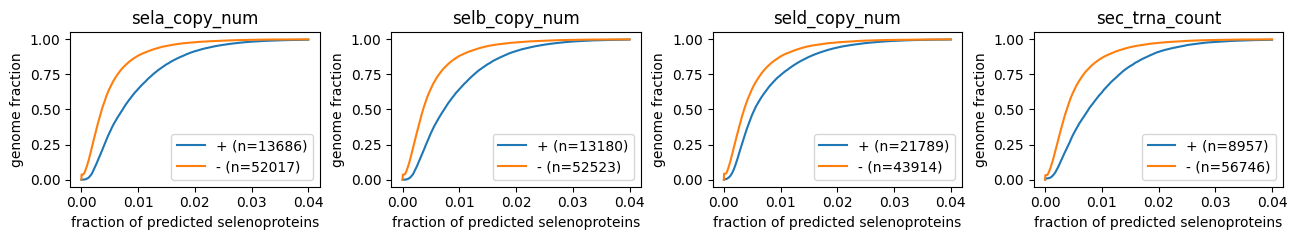

In [56]:
# Want to plot the ECDF of genomes with and without selA, selB, sectRNA, etc. with fraction of predicted selenoproteins on the x-axis. 

def plot_ecdf(sec_fractions_df:pd.DataFrame, ax:plt.Axes=None, max_x_value:float=None):
    # First get the ratios of predicted selenoproteins to total genes for each genome. 
    sec_fractions = sec_fractions_df.sec_fraction.values
    # Sort the genome IDs and selenoprotein fractions in increasing order. 
    # sec_fractions = np.sort(sec_fractions)
    x_vals = np.linspace(0, max_x_value, 1000)
    n = len(sec_fractions_df)
    y_vals = [np.sum(sec_fractions < x) / n for x in x_vals]
    ax.plot(x_vals, y_vals)

    return sec_fractions


fig, axes = plt.subplots(ncols=4, figsize=(13, 2.5))

sec_fractions_df = sec_fractions_df.fillna(0)
# split_on = 'sela_copy_num'
for split_on, ax in zip(['sela_copy_num', 'selb_copy_num', 'seld_copy_num', 'sec_trna_count'], axes):
    sec_fractions_df_pos = sec_fractions_df[sec_fractions_df[split_on] > 0]
    sec_fractions_df_neg = sec_fractions_df[sec_fractions_df[split_on] < 1]

    print(len(sec_fractions_df_neg) + len(sec_fractions_df_pos))
    # pos_y_vals = plot_ecdf(gtdb_results_df_pos, ax=ax, max_x_value=0.04)
    # neg_y_vals = plot_ecdf(gtdb_results_df_neg, ax=ax, max_x_value=0.04)

    pos_sec_fractions = plot_ecdf(sec_fractions_df_pos, ax=ax, max_x_value=0.04)
    neg_sec_fractions = plot_ecdf(sec_fractions_df_neg, ax=ax, max_x_value=0.04)

    # kstest_result = kstest(pos_y_vals, neg_y_vals)
    # print(f'K-S test p-value for {split_on}:', kstest_result.pvalue)
    mwu_result = mannwhitneyu(pos_sec_fractions, neg_sec_fractions)
    print(f'Mann-Whitney U test p-value for {split_on}:', mwu_result.pvalue)
    print(f'Mann-Whitney U test statistic for {split_on}:', mwu_result.statistic)


    ax.set_title(split_on)
    ax.legend([f'+ (n={len(sec_fractions_df_pos)})', f'- (n={len(sec_fractions_df_neg)})'])
    ax.set_ylabel('genome fraction')
    ax.set_xlabel('fraction of predicted selenoproteins')

plt.tight_layout()
plt.show()


In [59]:
old_gtdb_results_df = pd.read_csv('../results/old_gtdb_predictions.csv')
old_genome_ids = old_gtdb_results_df.genome_id.unique()

print('Number of genomes in old results:', len(old_genome_ids))
print('Number of predicted selenoproteins in old results:', len(old_gtdb_results_df[old_gtdb_results_df.prediction > 0]))


def get_gene_data(gene_ids:List[str], batch_size=100, output_path:str=None):
    # NOTE: As long as the batch size is less than 1000 (which I think is the default page size), should not need to paginate at all. 
    gene_data_df = []
    for batch in tqdm([gene_ids[i * batch_size:(i + 1) * batch_size] for i in range(len(gene_ids) // batch_size + 1)], desc='get_gene_data: Fetching gene data...'):
        query = Query('proteins')
        query.equal_to('gene_id', batch)
        gene_data_df.append(query.get())
    gene_data_df = pd.concat(gene_data_df)
    gene_data_df.set_index('gene_id').to_csv(output_path)
    print(f"get_gene_data: Gene and annotations data written to {output_path}")

# get_gene_data(old_gtdb_results_df.gene_id, output_path='../results/old_gtdb_gene_data.csv')

Number of genomes in old results: 6667
Number of predicted selenoproteins in old results: 174718


In [55]:
# gene_ids = []
# # Fix gene IDs that Josh messed up. 
# for gene_id in old_gtdb_results_df.gene_id:
#     gene_id = gene_id.split('_')
#     right = '_'.join(gene_id[-2:])
#     left = '_'.join(gene_id[:2])
#     gene_ids.append(left + '.' + right)
# old_gtdb_results_df['gene_id'] = gene_ids
# old_gtdb_results_df.set_index('gene_id').to_csv('../results/old_gtdb_predictions.csv')

Number of annotated predicted selenoproteins: 445884


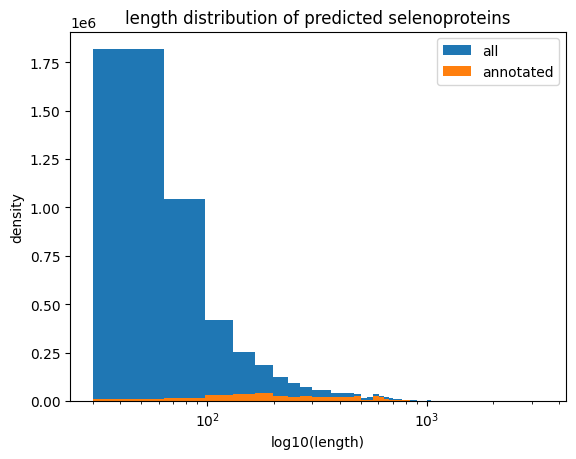

In [63]:
lengths = gtdb_results_df.aa_seq.apply(len)
annotated_lengths = gtdb_results_df[~gtdb_results_df.ko.isnull()].aa_seq.apply(len) 
# old_lengths = pd.read_csv('../results/old_gtdb_gene_data.csv').aa_seq.apply(len)
print('Number of annotated predicted selenoproteins:', len(annotated_lengths))

fig, ax = plt.subplots()
_, bins, _ = ax.hist(lengths, bins=100)
ax.hist(annotated_lengths, bins=bins)
# ax.hist(old_lengths, bins=100, density=True)

# ax.legend(['new results', 'old results'])
ax.legend(['all', 'annotated'])
ax.set_title('length distribution of predicted selenoproteins')

ax.set_ylabel('density')
ax.set_xlabel('log10(length)') # Defaults to base 10. 
ax.set_xscale('log')

plt.show()

In [ ]:
# # Should I normalize by genome size? Seems like if I don't normalize the copy number by genome size, I shouldn't normalize the
# # number of predicted selenoproteins. 

# #MAX_COPY_NUM = 4
# #X_VALS = np.linspace(0, MAX_COPY_NUM, num=100)
# N_BOOTSTRAPS = 50

# def get_copy_num_correlation(gtdb_results_df:pd.DataFrame, gene:str='sela') -> dict:
#     '''Compute the correlation between the copy number of the specified selenoprotein-associated gene and the number of predicted
#     selenoproteins in the genome.'''
#     x, y = [], []

#     for copy_num, df in gtdb_results_df.groupby(f'{gene}_copy_num'): # Group genomes by copy number. 
#         sec_per_genome = df.groupby('genome_id', sort=False).apply(len, include_groups=False).values #  / df.drop_duplicates('genome_id').protein_count.values
#         # y.append(np.mean(sec_per_genome)) # Get the mean number of predicted selenoproteins per genome.
#         # x.append(np.array(copy_num))
#         y += list(sec_per_genome)
#         x += list(np.array([copy_num] * len(sec_per_genome))) # / df.drop_duplicates('genome_id').protein_count.values)
    
#     results = dict()
#     results['x'] = np.array(x)
#     results['y'] = np.array(y)
#     results['spearman_r'] = scipy.stats.spearmanr(x, y).statistic
#     results['pearson_r'] = scipy.stats.pearsonr(x, y).statistic

#     return results


# def bootstrap_copy_num_correlation(gtdb_results_df:pd.DataFrame, n_bootstraps:int=N_BOOTSTRAPS, gene:str='sela', ax:plt.Axes=None) -> Tuple:
#     pearson_r, spearman_r = [], []
#     n = len(gtdb_results_df)

#     def sample(df:pd.DataFrame):
#         '''Sample such that the same number of points from each copy number are randomly-sampled.'''
#         sample_df = []
#         for copy_num, df in df.groupby(f'{gene}_copy_num'):
#             df = df.sample(frac=1, replace=True)
#             df['copy_num'] = copy_num
#             sample_df.append(df)
#         return pd.concat(sample_df)

#     # Do I want to sample from the entire results DataFrame? Or from each individual copy number?

#     for _ in range(n_bootstraps):
#         results = get_copy_num_correlation(sample(gtdb_results_df), gene=gene) 
#         # results = get_copy_num_correlation(gtdb_results_df.sample(frac=1, replace=True))

#         if ax is not None: # Plot the best-fit line, if an axis is provided.
#             x_vals = np.linspace(0, max(results['x']), 100)
#             slope, intercept = np.polyfit(results['x'], results['y'], deg=1) # Get the best fit line for the correlation. 
#             ax.plot(x_vals, x_vals * slope + intercept, c='tab:gray', alpha=0.1)
        
#         pearson_r.append(results['pearson_r'])
#         spearman_r.append(results['spearman_r'])

#     return np.array(pearson_r), np.array(spearman_r)


# def plot_copy_num_correlation(gtdb_results_df:pd.DataFrame, gene:str='sela', ax:plt.Axes=None):

#     results = get_copy_num_correlation(gtdb_results_df, gene=gene)

#     pearson_r, spearman_r = bootstrap_copy_num_correlation(gtdb_results_df, gene=gene, ax=ax, n_bootstraps=N_BOOTSTRAPS)
#     # pearson_p = np.sum(results['pearson_r'] > pearson_r) / N_BOOTSTRAPS
#     # spearman_p = np.sum(results['spearman_r'] > spearman_r) / N_BOOTSTRAPS
#     x_vals = np.linspace(0, max(results['x']), 100)

#     # scatter_x = np.arange(MAX_COPY_NUM)
#     # scatter_y = [np.mean(results['y'][results['x'] == i]) for i in scatter_x]
#     ax.scatter(results['x'], results['y'], c='tab:blue', s=2)

#     slope, intercept = np.polyfit(results['x'], results['y'], deg=1) # Get the best fit line for the correlation. 
#     ax.plot(x_vals, x_vals * slope + intercept, c='tab:blue')

#     conf_low, conf_high = np.round(np.quantile(pearson_r, 0.025), 2), np.round(np.quantile(pearson_r, 0.975), 2)
#     ax.text(0.2, 0.1, 'Pearson\'s R: ' + str(np.round(results['pearson_r'], 2)) + f' (95% conf. {conf_low} to {conf_high})', transform=ax.transAxes, fontsize='x-small')
#     conf_low, conf_high = np.round(np.quantile(spearman_r, 0.025), 2), np.round(np.quantile(spearman_r, 0.975), 2)
#     ax.text(0.2, 0.15,'Spearman\'s R: ' + str(np.round(results['spearman_r'], 2)) + f' (95% conf. {conf_low} to {conf_high})', transform=ax.transAxes, fontsize='x-small')

# fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# for ax, gene in zip(axes, ['selA', 'selB', 'selD']):
#     plot_copy_num_correlation(gtdb_results_df, ax=ax, gene=gene.lower())
#     ax.set_xlabel('copy number')
#     ax.set_ylabel('number of predicted selenoproteins')
#     ax.set_title(gene)

# plt.tight_layout()
# plt.show()